Project plan,
1. Vector autoregression
    1. Confirm stationarity using ADF
    2. Create [VAR model](https://www.statsmodels.org/dev/vector_ar.html)
    3. Tests: Granger causality, residual whiteness
    4. Create impulsive response function visualization
2. Detrended Fluctuation Analysis (DFA)
    1. Run DFA via [fathon](https://fathon.readthedocs.io/en/latest/fun_class/fathon.DFA.html)
    2. Plot DFA indicator over time against mood
3. ML for time series
    1. [Dictionary-based (TDE)](https://github.com/sktime/sktime/blob/main/sktime/classification/dictionary_based/_tde.py)
    2. [Annotation (HMM)](https://github.com/sktime/sktime/blob/main/sktime/annotation/hmm.py)

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import altair as alt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR

In [133]:
mood = pd.read_csv('../data/emoods.csv', parse_dates=['DATE (YYYY-MM-DD)'], usecols=['DATE (YYYY-MM-DD)', 'IRRITABILITY', 'ANXIETY', 'DEPRESSED', 'ELEVATED']).rename(columns={'DATE (YYYY-MM-DD)':'date', 'IRRITABILITY':'irritable', 'ANXIETY':'anxious', 'DEPRESSED':'depressed','ELEVATED':'elevated'}).set_index('date')
sleep = pd.read_csv('../data/oura_sleep_2023-03-03T12-21-33.csv', parse_dates=['day', 'bedtime_end', 'bedtime_start']).set_index('day')
sleep_scores = pd.read_csv('../data/oura_daily-sleep_2023-03-03T12-20-39.csv', parse_dates=['day']).rename(columns={'contributors_timing':'timing', 'contributors_deep_sleep':'deep', 'contributors_restfulness':'restfulness', 'contributors_efficiency':'efficiency', 'contributors_latency':'latency','contributors_rem_sleep':'rem', 'contributors_total_sleep':'total'}).set_index('day')

In [134]:
print(mood[['irritable' ,'anxious','depressed','elevated']].sum().to_latex())

\begin{tabular}{lr}
\toprule
{} &    0 \\
\midrule
irritable &  218 \\
anxious   &  198 \\
depressed &  229 \\
elevated  &   84 \\
\bottomrule
\end{tabular}



/var/folders/h2/j2rcc6sn4_vcqzgfkx3nnts40000gn/T/ipykernel_42288/2105172271.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(mood[['irritable','anxious','depressed','elevated']].sum().to_latex())


In [135]:
ts = sleep_scores.join(mood)

In [136]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1456 entries, 2019-02-05 to 2023-03-03
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   score        1455 non-null   float64
 1   timing       1455 non-null   float64
 2   deep         1455 non-null   float64
 3   restfulness  1455 non-null   float64
 4   efficiency   1455 non-null   float64
 5   latency      1455 non-null   float64
 6   rem          1455 non-null   float64
 7   total        1455 non-null   float64
 8   irritable    735 non-null    float64
 9   anxious      735 non-null    float64
 10  depressed    735 non-null    float64
 11  elevated     735 non-null    float64
dtypes: float64(12)
memory usage: 180.2 KB


In [137]:
alt.Chart(ts.reset_index()).mark_line().encode(
    x='day:T',
    y='score:Q'
)

alt.Chart(...)

In [138]:
test_ts = ts['score'].dropna()

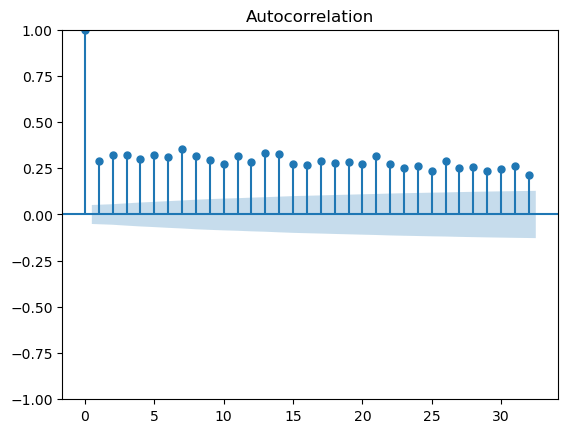

In [139]:
plot_acf(test_ts);

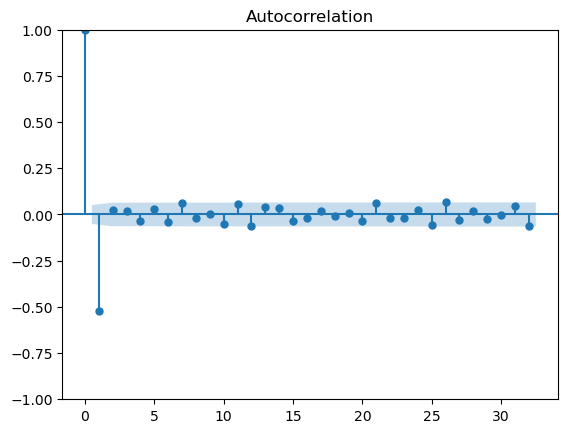

In [140]:
plot_acf(test_ts.diff(), missing='drop');

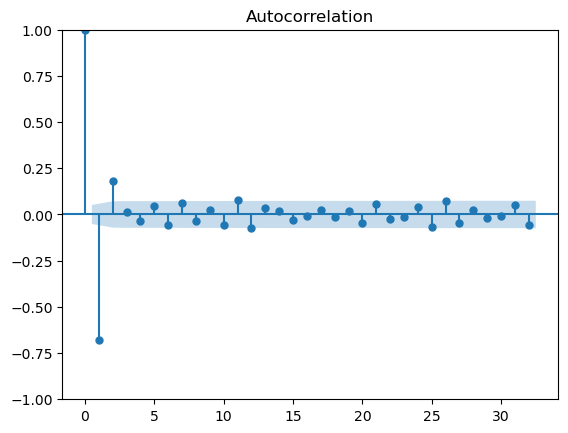

In [141]:
plot_acf(test_ts.diff().diff(), missing='drop');

/opt/homebrew/Caskroom/miniforge/base/envs/stat508/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


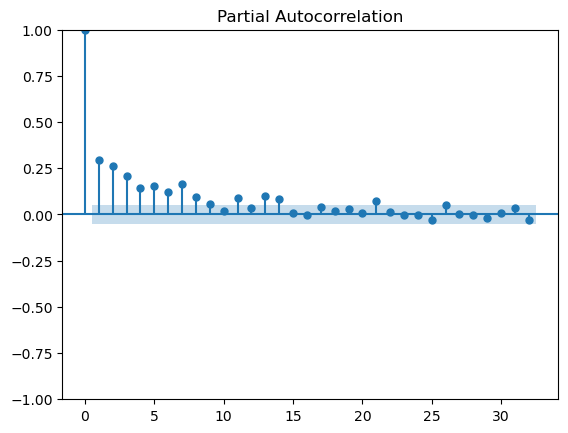

In [142]:
plot_pacf(test_ts);

In [143]:
def test_stationarity(timeseries):
    
    # set figure size
    fig = plt.figure(figsize=(18,8))
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(window=7).mean() 
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [144]:
from pmdarima.arima.utils import ndiffs

def test_arima(timeseries):
    Adf_Test = ndiffs(timeseries, test='adf')  
    KPSS_Test = ndiffs(timeseries, test='kpss')  
    PP_Test = ndiffs(timeseries, test='pp')  

    print('Number of differences to make stationary, via pymdarima library')
    print('ADF: ', Adf_Test, 'KPSS: ', KPSS_Test, 'PP: ', PP_Test) 


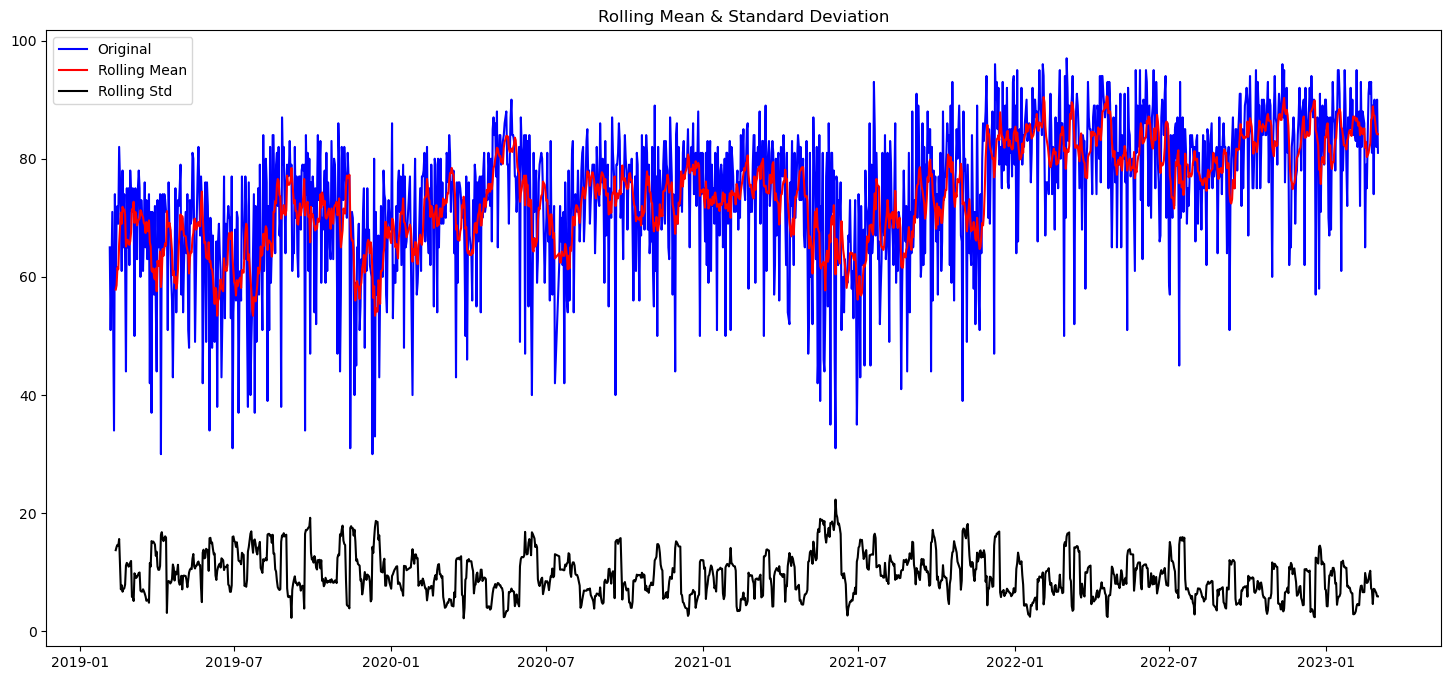

Results of Dickey-Fuller Test:
Test Statistic                   -3.406686
p-value                           0.010733
#Lags Used                       13.000000
Number of Observations Used    1441.000000
Critical Value (1%)              -3.434896
Critical Value (5%)              -2.863548
Critical Value (10%)             -2.567839
dtype: float64
Number of differences to make stationary, via pymdarima library
ADF:  0 KPSS:  1 PP:  0


In [145]:
test_stationarity(test_ts)
test_arima(test_ts)

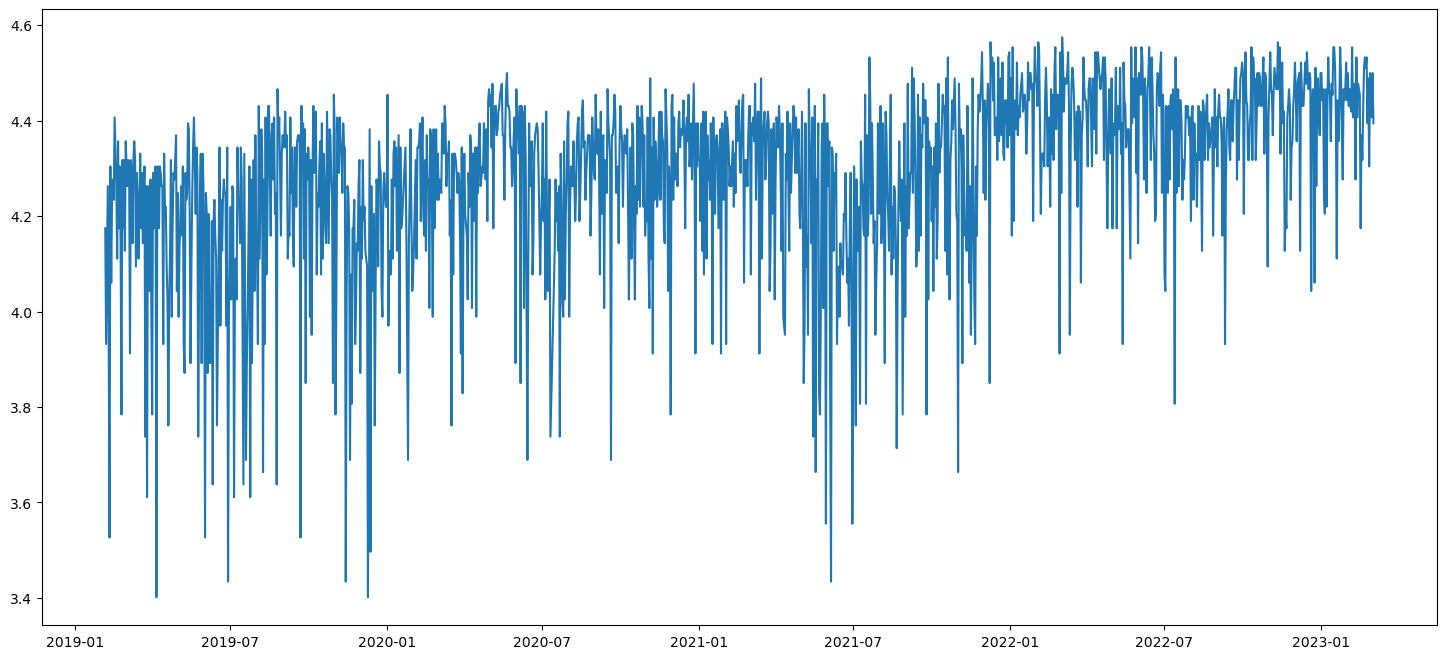

In [146]:
fig = plt.figure(figsize=(18,8))

ts_log = np.log(test_ts).dropna()
plt.plot(ts_log)

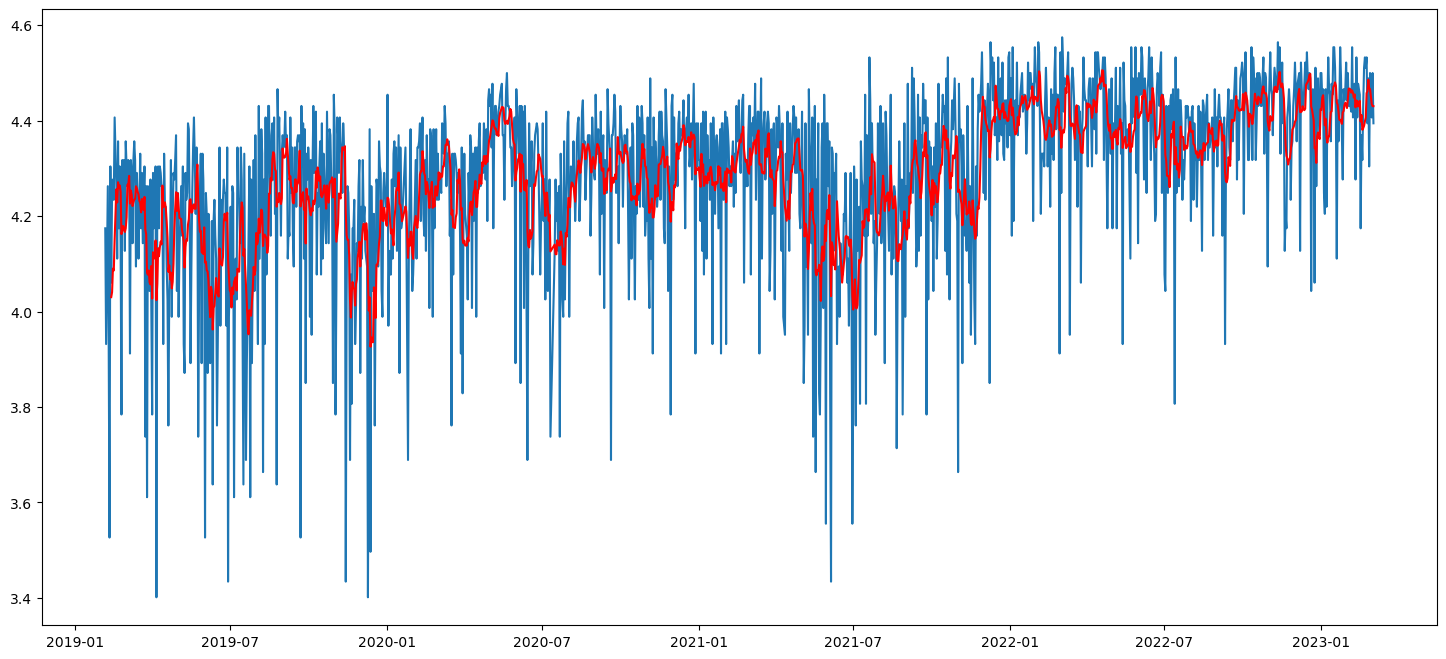

In [147]:
fig = plt.figure(figsize=(18,8))

moving_avg = ts_log.rolling(window=7).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [148]:
ts_log_moving_avg_diff = ts_log - moving_avg

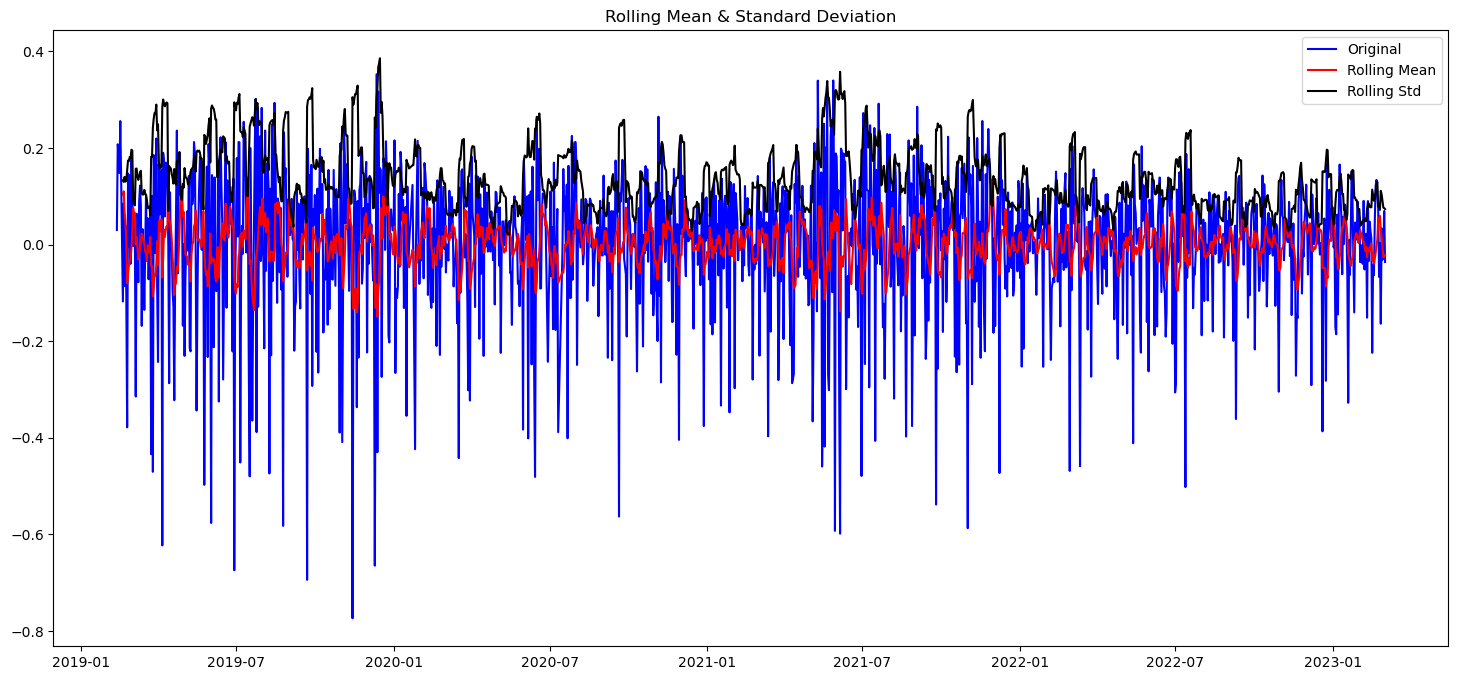

Results of Dickey-Fuller Test:
Test Statistic                -1.399411e+01
p-value                        3.968099e-26
#Lags Used                     1.500000e+01
Number of Observations Used    1.433000e+03
Critical Value (1%)           -3.434922e+00
Critical Value (5%)           -2.863559e+00
Critical Value (10%)          -2.567845e+00
dtype: float64


In [149]:
test_stationarity(ts_log_moving_avg_diff.dropna())

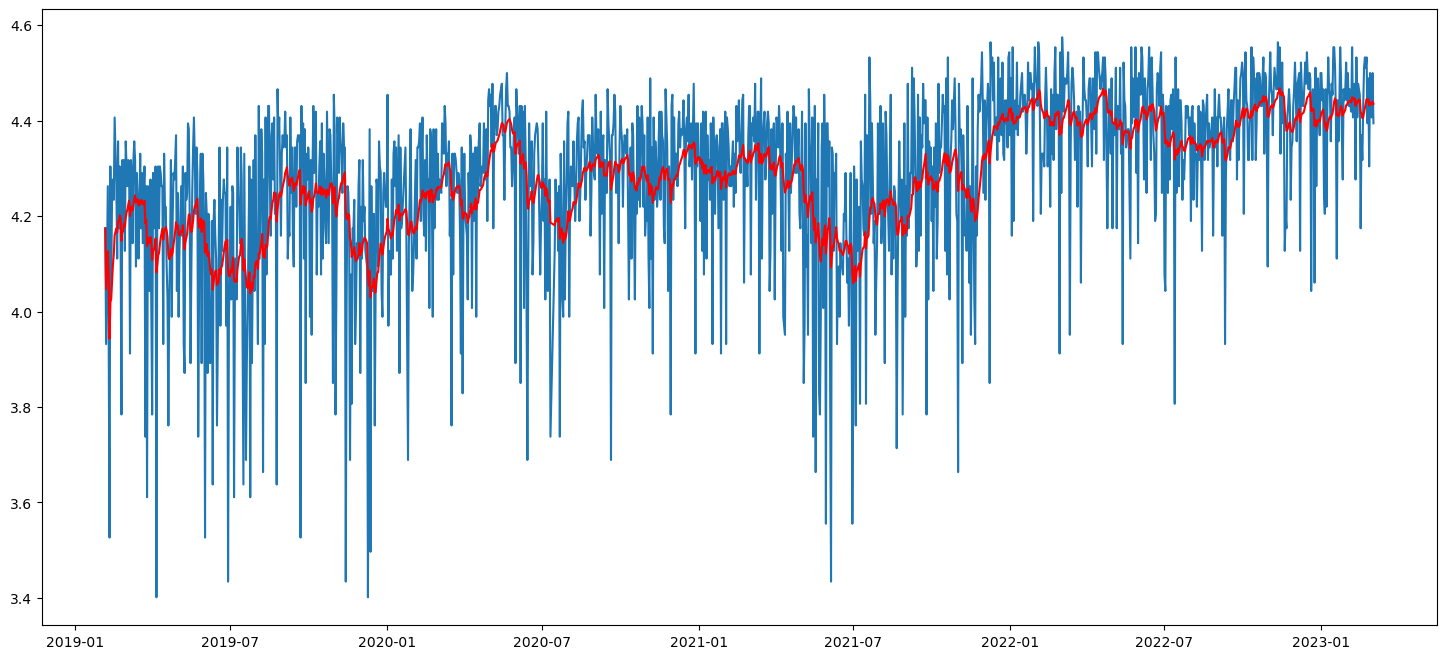

In [150]:
fig = plt.figure(figsize=(18,8))

expweighted_avg = ts_log.ewm(halflife=7).mean()
plt.plot(ts_log)
plt.plot(expweighted_avg, color='red')

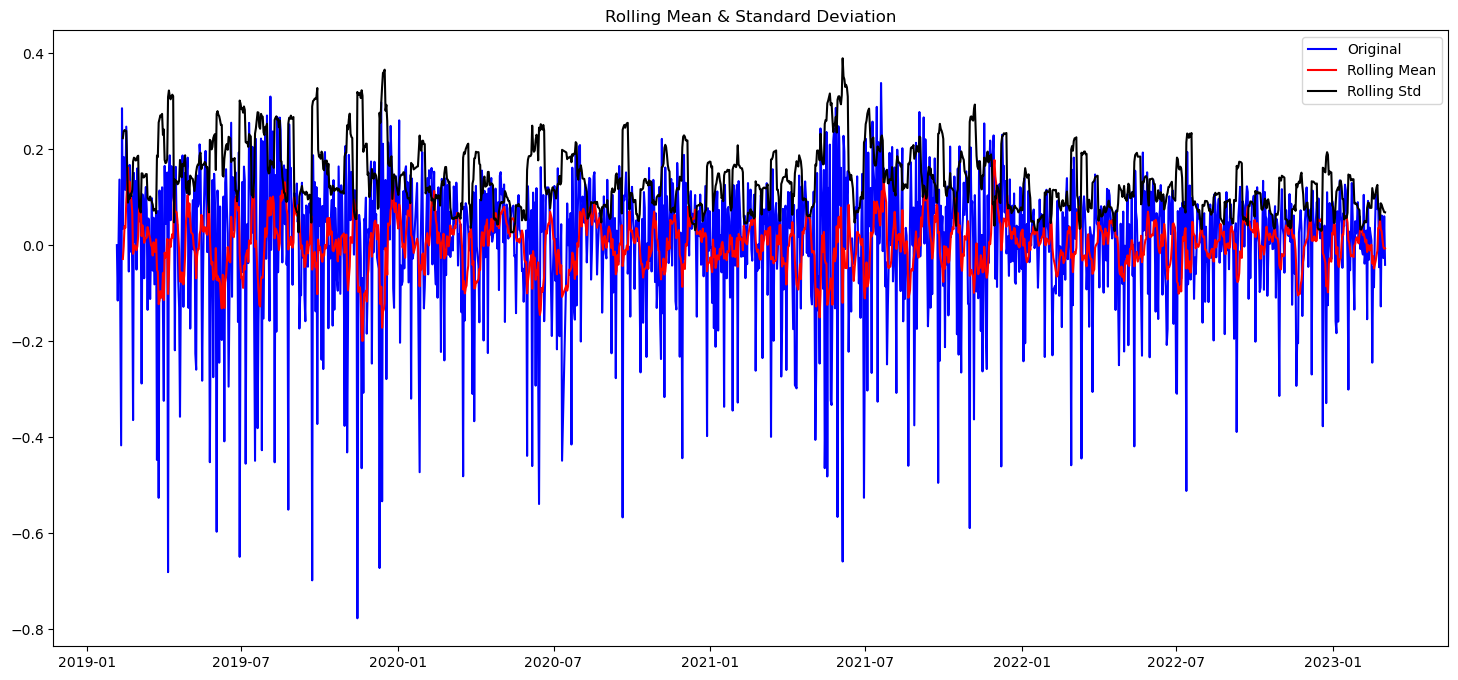

Results of Dickey-Fuller Test:
Test Statistic                -1.307243e+01
p-value                        1.944633e-24
#Lags Used                     9.000000e+00
Number of Observations Used    1.445000e+03
Critical Value (1%)           -3.434884e+00
Critical Value (5%)           -2.863542e+00
Critical Value (10%)          -2.567836e+00
dtype: float64
Number of differences to make stationary, via pymdarima library
ADF:  0 KPSS:  1 PP:  0


In [151]:
ts_log_ewma_diff = ts_log - expweighted_avg
test_stationarity(ts_log_ewma_diff)
test_arima(test_ts)

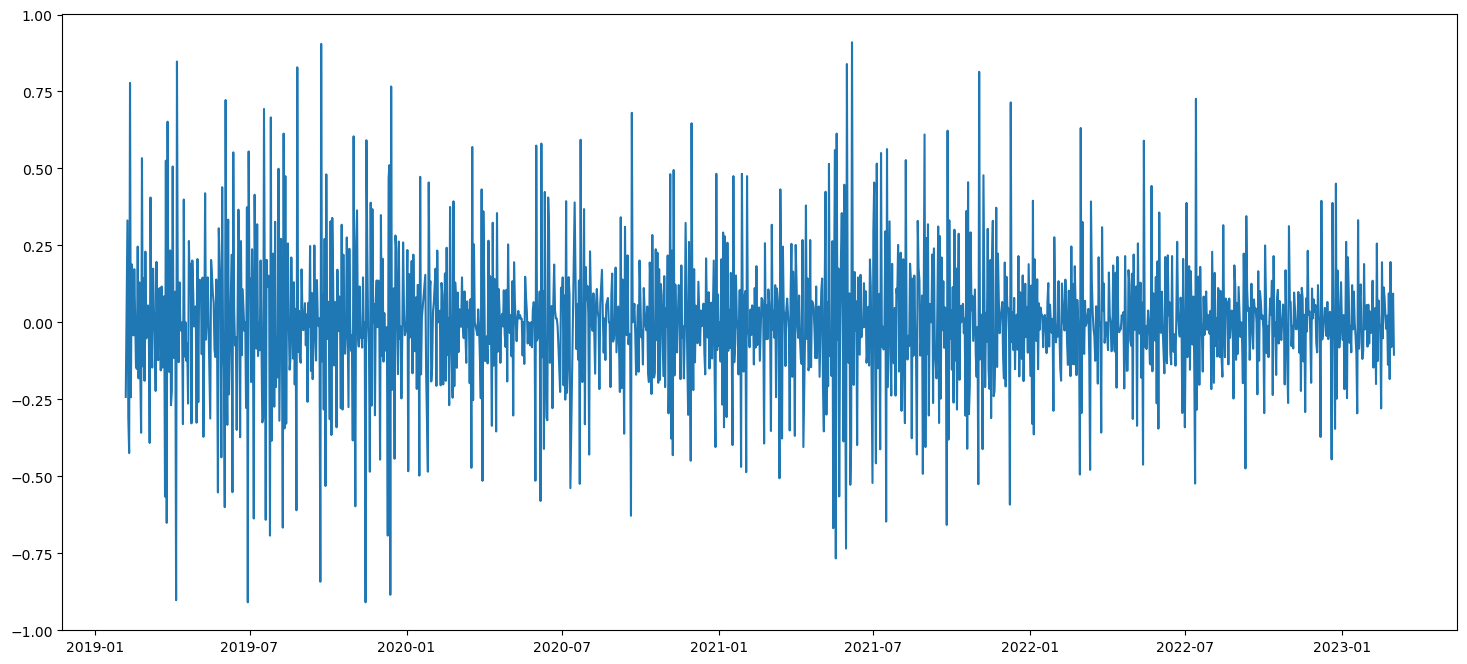

In [152]:
fig = plt.figure(figsize=(18,8))

ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

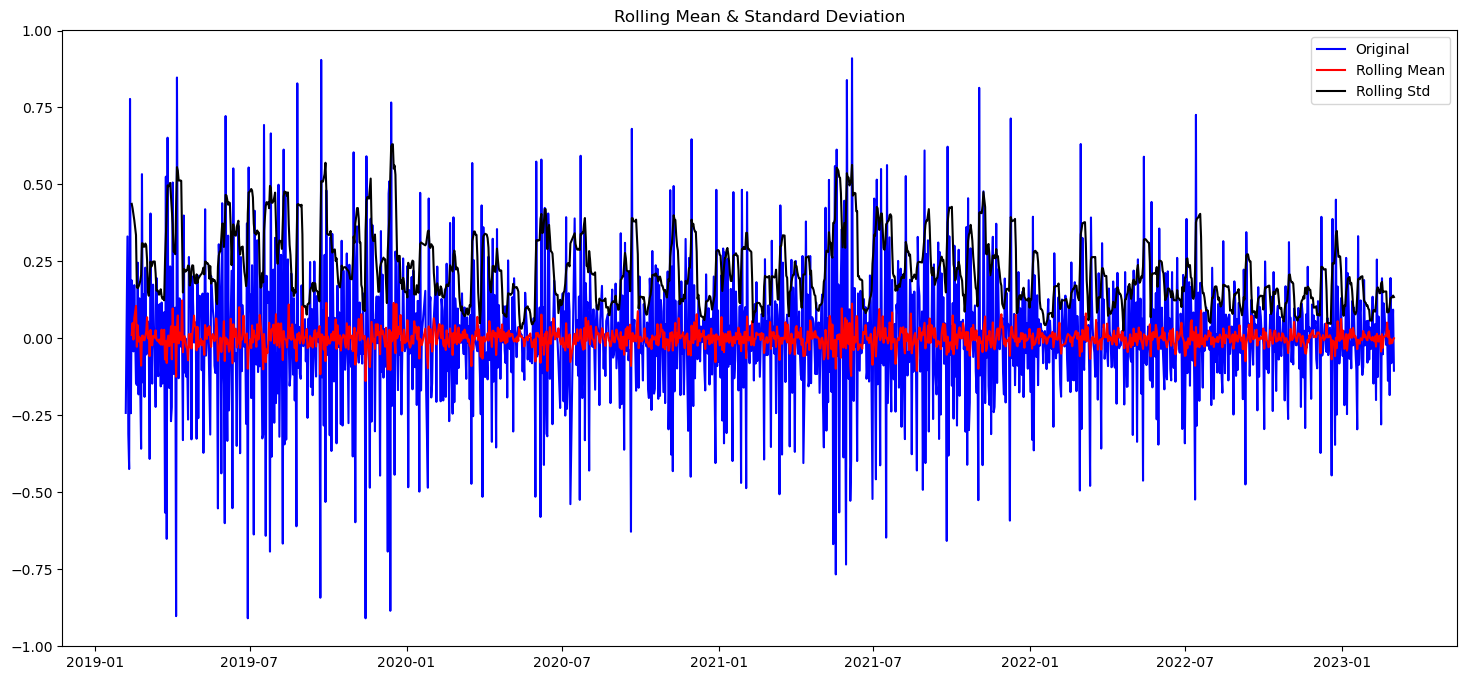

Results of Dickey-Fuller Test:
Test Statistic                -1.373909e+01
p-value                        1.103040e-25
#Lags Used                     1.900000e+01
Number of Observations Used    1.434000e+03
Critical Value (1%)           -3.434918e+00
Critical Value (5%)           -2.863558e+00
Critical Value (10%)          -2.567844e+00
dtype: float64
Number of differences to make stationary, via pymdarima library
ADF:  0 KPSS:  1 PP:  0


In [153]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)
test_arima(test_ts)

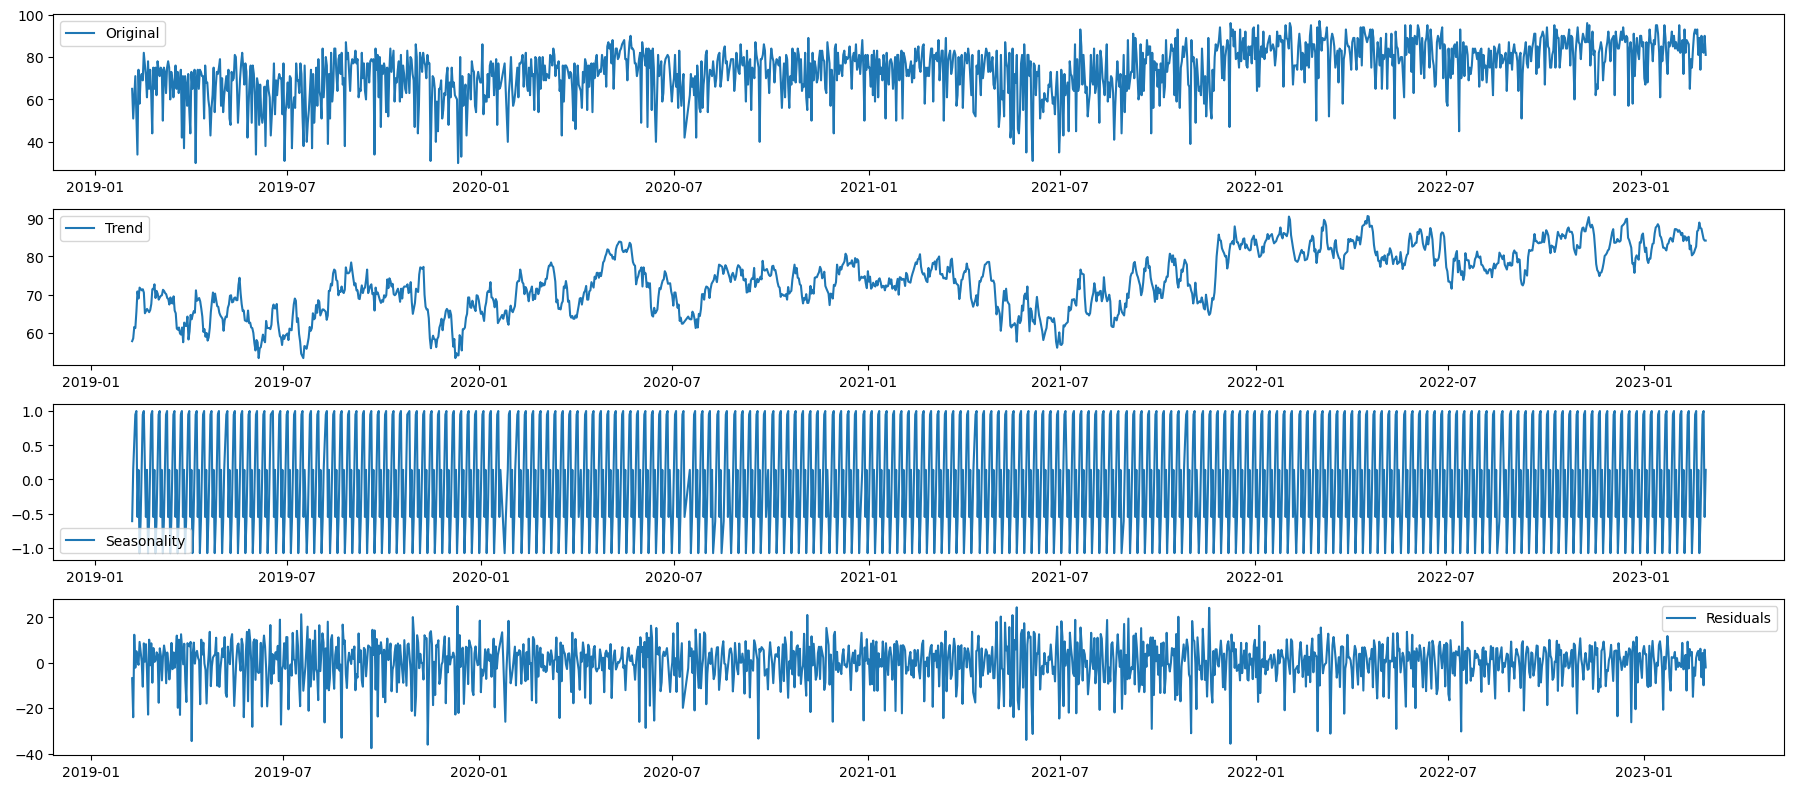

In [154]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(test_ts, period=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(18,8))

plt.subplot(411)
plt.plot(test_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

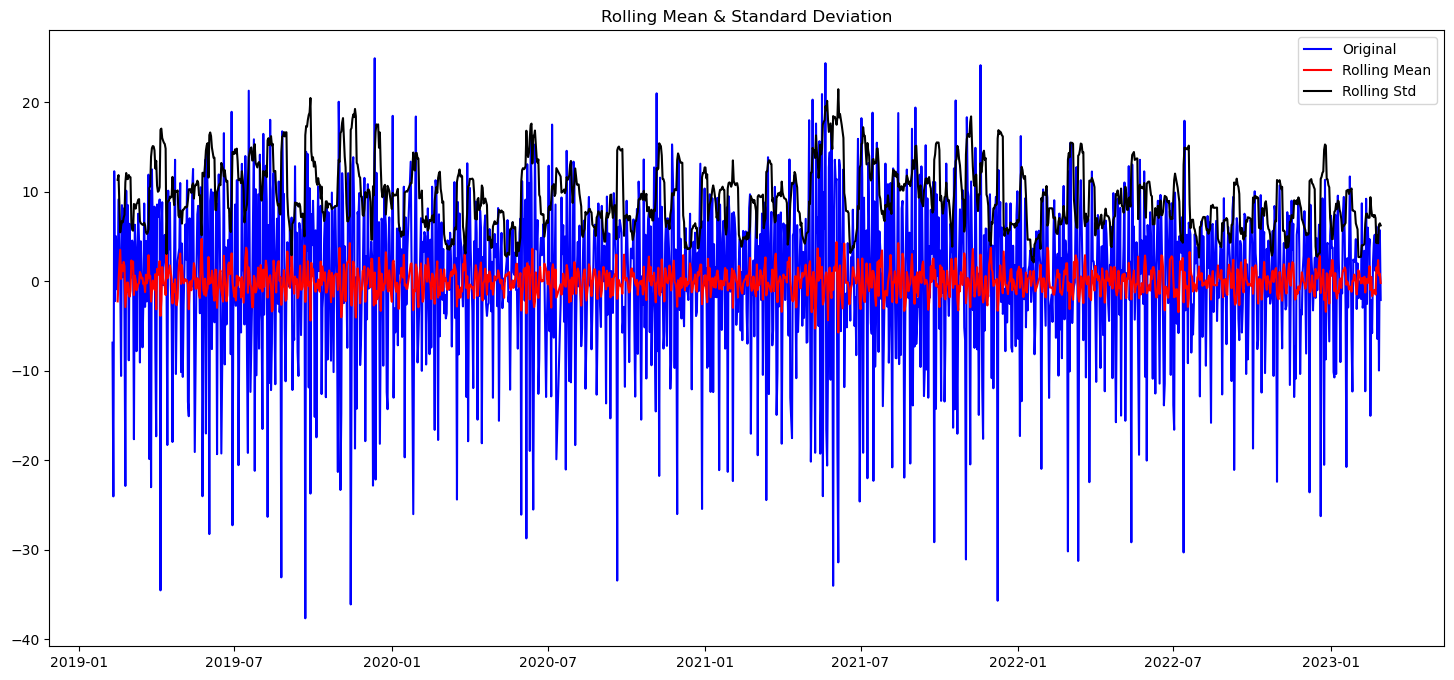

Results of Dickey-Fuller Test:
Test Statistic                -1.619279e+01
p-value                        4.153893e-29
#Lags Used                     2.400000e+01
Number of Observations Used    1.424000e+03
Critical Value (1%)           -3.434951e+00
Critical Value (5%)           -2.863572e+00
Critical Value (10%)          -2.567852e+00
dtype: float64
Number of differences to make stationary, via pymdarima library
ADF:  0 KPSS:  1 PP:  0


In [155]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)
test_arima(test_ts)

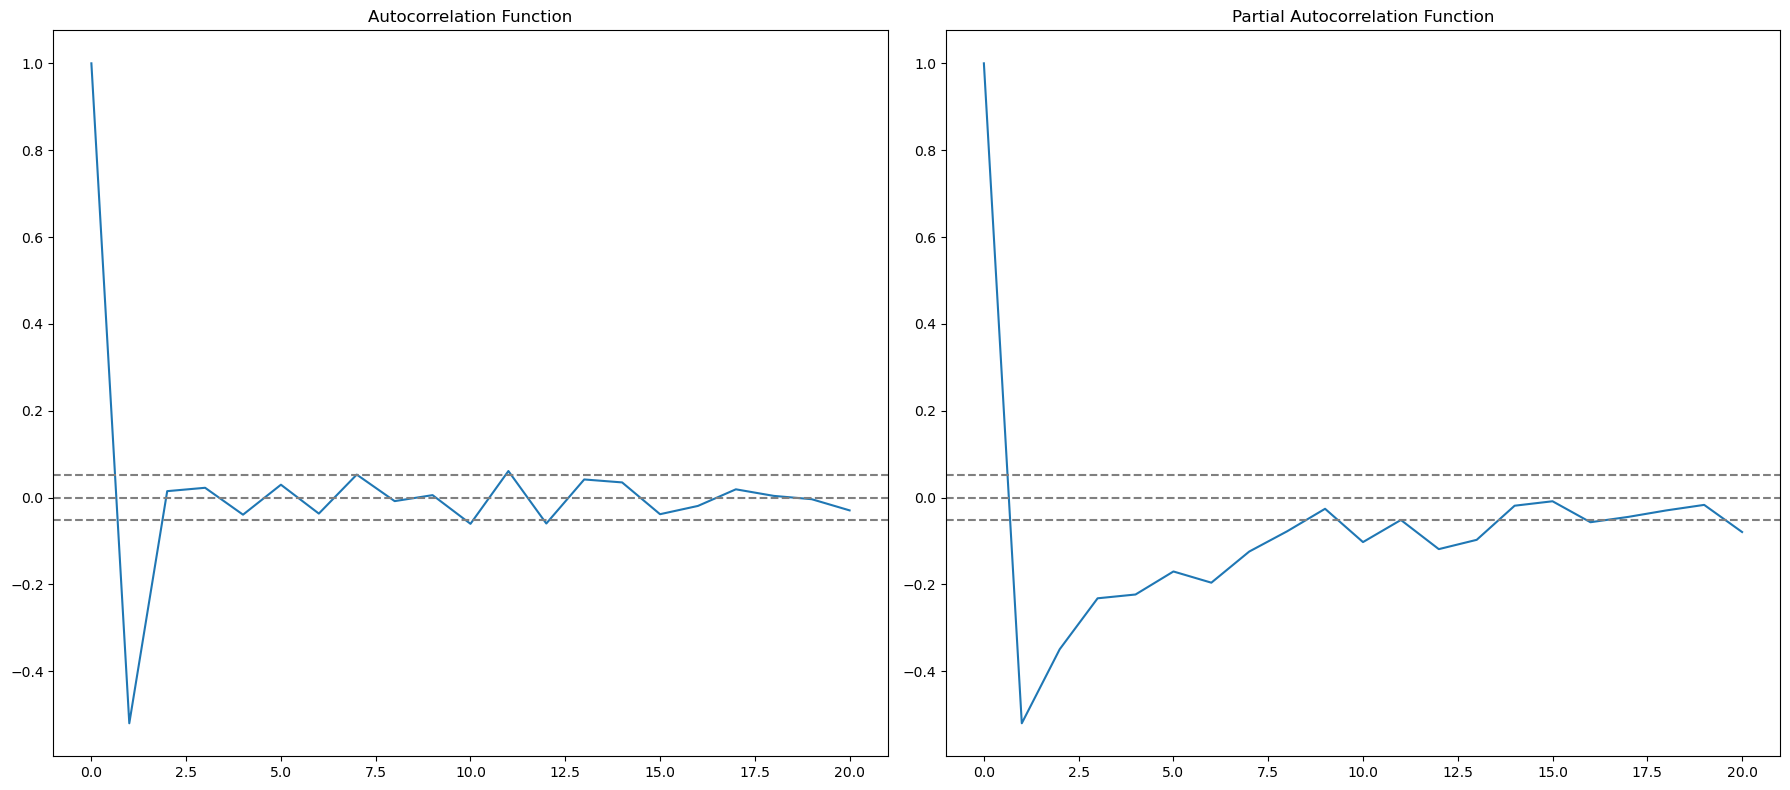

In [156]:
from statsmodels.tsa.stattools import acf, pacf

fig = plt.figure(figsize=(18,8))

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [ ]:
from pyts.bag_of_words import BagOfWords

